# Libraries

In [128]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from unidecode import unidecode

# Data Loading

In [129]:
csv_filename = "ares_test_data.csv"
data = pd.read_csv(csv_filename)
print(data.head(10))

     description   stage  duration
0  desc stage1 1  stage1         3
1  desc stage2 1  stage2         2
2  desc stage3 1  stage3         3
3  desc stage2 1  stage2         3
4  desc stage1 1  stage1         1
5  desc stage2 1  stage2         1
6  desc stage3 1  stage3         2
7  desc stage2 1  stage2         3
8  desc stage1 1  stage1         2
9  desc stage3 1  stage3         3


# Data Cleaning

In [130]:
def get_all_characters() -> list:
    """
    @returns all the characters relevant for the model. Right now it is all the printable characters
    """
    all_characters: list = []
    # all_letters: list = list(string.ascii_letters)
    # all_digits = ["0","1","2","3","4","5","6","7","8","9"]
    printable_characters = list(string.printable)
    all_characters = printable_characters
    return all_characters

print(get_all_characters())

def get_relevant_columns_names() -> list:
    relevant_columns_names = ["stage", "description", "duration"]
    return relevant_columns_names


def get_clean_text(text: str) -> str:
    """
    @return string with only relevant characters to the model
    """
    all_characters = get_all_characters()
    character_list = list(text)

    for char in character_list:
        if char not in all_characters:
            text = text.replace(char, "")
    return text


def get_relevant_columns(df: pd.DataFrame):
    rcn = get_relevant_columns_names()
    return df[rcn]


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ', '\t', '\n', '\r', '\x0b', '\x0c']


In [131]:
data = get_relevant_columns(data)
data['description'] = data['description'].apply(get_clean_text) 
print(data.head())

    stage    description  duration
0  stage1  desc stage1 1         3
1  stage2  desc stage2 1         2
2  stage3  desc stage3 1         3
3  stage2  desc stage2 1         3
4  stage1  desc stage1 1         1


# Model Creation

## Strings operations

In [132]:

def get_number_of_characters(s: str)->int:
    return len(s.replace(" ", ""))

def get_character_index(s: str)->int:
    all_characters: list = get_all_characters()
    index = all_characters.index(s)
    return index

## Biagram

In [133]:
# create matrix with biagram
def create_biagram() -> np.array:
    """
    @return a matrix filled with zeroes of size n_char x n_char
    """
    # The only characters we are going to consider.
    all_characters: list = get_all_characters()
    n_characters = len(all_characters)
    # create the matrix of size n_characters
    biagram: np.array = np.zeros((n_characters, n_characters))
    return biagram


def get_stage_descriptions(df: pd.DataFrame, stage: str) -> pd.DataFrame:
    """
    @input
        df: Dataframe with all the information.
        stage: stage to extract
    @return list with all the descriptions of the given stage
    """
    column_name: str = "stage"
    mask = df[column_name] == stage
    return df[mask][column_name]


def get_character_count(descriptions: pd.DataFrame) -> dict:
    """
    @input description: df with all the description of a stage.
    @return dictionary with character count of all the descriptions in a stage. 
    """
    all_characters = get_all_characters()
    character_count: dict = {}
    for description in descriptions:
        for character in all_characters:
            character_count[character] = description.count(character)
    return character_count


def get_filled_biagram(descriptions: pd.DataFrame) -> np.array:
    """
    @input list of all the descriptions for a stage
    @return matrix with character count, and the count of the next character
    """
    # create the matrix of size n_characters
    biagram: np.array = create_biagram()
    for description in descriptions:
        for index in range(0, len(description) - 1):
            # check current and next character
            current_character = description[index]
            current_character_index = get_character_index(current_character)

            next_character = description[index + 1]
            next_character_index = get_character_index(next_character)

            current_biagram_value = biagram[current_character_index][
                next_character_index
            ]
            biagram[current_character_index][next_character_index] = (
                current_biagram_value + 1
            )
    return biagram


## Probability Matrix

In [134]:
def normalize_probabilities(character_count: int, total_characters: int)->float:
    return character_count/total_characters

def get_marginal_probabilities(character_count: dict, text:str)->np.array:
    """
    @input 
        character_count: Dictionary with occurences of each character
        text: the text to analyse
    """
    character_probabilities = np.zeros(len(string.ascii_lowercase))
    n_characters = get_number_of_characters(text)
    for char in character_count.keys():
        index = list(character_count.keys()).index(char)
        character_probabilities[index] = normalize_probabilities(character_count[char], n_characters)+0.00001
    return character_probabilities

def get_cond_probabilities(joint_probability: np.array,marginal_probability: np.array)->np.array:
    conditional_probability = (joint_probability.T/marginal_probability).T
    # normalized matrix
    conditional_probability = conditional_probability/conditional_probability.sum() 
    prob_sum = conditional_probability.sum()
    print(f"prob_sum = {prob_sum}")
    return conditional_probability

def get_joint_probabilities(characters_count: np.array)->np.array:
    all_characters = get_all_characters()
    # + len(all_characters) to account for repetitions (aa, bb, cc, dd, etc.)
    n_pairs = characters_count.sum()
    joint_probability_matrix = create_biagram()
    prob_sum = 0
    for i, row in enumerate(characters_count):
        for j,count in enumerate(characters_count):
            joint_probability_matrix[i][j] = normalize_probabilities(characters_count[i][j], n_pairs)
            prob_sum = prob_sum + joint_probability_matrix[i][j]
    print(f"prob_sum = {prob_sum}")
    return joint_probability_matrix

In [139]:
def graph_matrix_heatmap(matrix: np.array):
    all_characters = get_all_characters()
    # fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(matrix, cmap="Blues" ,annot=False, xticklabels=False, yticklabels=False)
    plt.xticks(rotation=0)
    plt.show()

## Model Creation

# Stage 1

prob_sum = 1.0


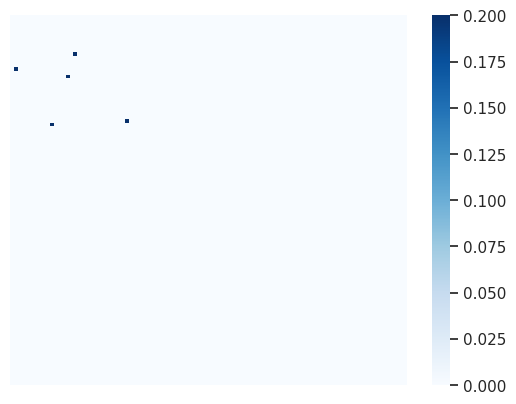

In [140]:
stage1_descriptions = get_stage_descriptions(data, "stage1")
STAGE1_dist = get_filled_biagram(stage1_descriptions)
STAGE1_dist = get_joint_probabilities(STAGE1_dist)
graph_matrix_heatmap(STAGE1_dist)
